# Casimir Athena

[Athena](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/athena.html) integrated data environment and query sandbox

## Table of Contents

* [Install Packages](#install-packages)
* [Configure Athena](#configure-athena)
* [Configure Plotting](#configure-plotting)
* [Introspect Schema](#introspect-schema)
* [Sample Usage](#sample-usage)
  * [Top New Stakes 2021](#top-new-stakes-2021)

## Install Packages

The primary package is [pyathena](https://pypi.org/project/pyathena/), a library for querying Amazon Athena and retrieving results with ease.

In [10]:
# Interact with AWS credentials and environment overrides
import os
from dotenv import load_dotenv
import boto3
import boto3.session

# Query Athena
from pyathena import connect

# Handle results
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

## Configure Athena

We use the AWS credentials from your configured AWS profile (default `consensus-networks-dev`) to initialize the pyathena connection and define a DB query method.

In [11]:
load_dotenv()
PROFILE=os.getenv('PROFILE')
profile = PROFILE or 'consensus-networks-dev'
session = boto3.Session(profile_name=profile)
creds = session.get_credentials()

connection = connect(
    aws_access_key_id=creds.access_key, 
    aws_secret_access_key=creds.secret_key, 
    s3_staging_dir="s3://casimir-etl-output-bucket-dev/", 
    region_name="us-east-2"
)

def db_query(sql_query: str) -> pd.DataFrame:
    """Execute SQL Query and get pandas dataframe"""
    with warnings.catch_warnings():
        # Ignore warning for non-SQLAlchemy connecton
        warnings.simplefilter('ignore', UserWarning)
        df = pd.read_sql_query(sql_query, connection)
    return df

> 🚩 You can override the default profile name by setting PROFILE in your project root `.env` file. See [Environment](../../../README.md#environment) for more information.

## Configure Plotting

We have some custom plotting and formatting functions that can be helpful to visualize the results of Athena queries.

In [12]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

month_day = DateFormatter("%m-%d")
number_commas = plt.FuncFormatter(lambda x, p: format(int(x), ','))

## Introspect Schema

View the current Glue tables stored in [common/data/src/schemas](common/data/src/schemas).

In [13]:
current_dir = os.getcwd()

event_json = pd.read_json('file://' + current_dir + '/../../src/schemas/event.schema.json')
agg_json = pd.read_json('file://' + current_dir + '/../../src/schemas/agg.schema.json')

print('-'*70)

print('\u0332'.join('Event Table'))
print ("{:<25} {:<10} {:<35}".format('Property', 'Type', 'Description'))
for key in event_json.properties.keys():
    type = event_json.properties[key]['type']
    description = event_json.properties[key]['description']
    print ("{:<25} {:<10} {:<35}".format(key, type, description))

print('-'*70)

print('\u0332'.join('Agg Table'))
print ("{:<25} {:<10} {:<35}".format('Property', 'Type', 'Description'))
for key in agg_json.properties.keys():
    type = agg_json.properties[key]['type']
    description = agg_json.properties[key]['description']
    print ("{:<25} {:<10} {:<35}".format(key, type, description))

print('-'*70)

----------------------------------------------------------------------
E̲v̲e̲n̲t̲ ̲T̲a̲b̲l̲e
Property                  Type       Description                        
address                   string     The address that initiated the event
amount                    string     The amount of the currency in the event
auto_stake                boolean    Is auto staking enabled            
candidate                 string     The name of the candidate associated the event
candidate_list            array      The list of candidates in a stake action
chain                     string     Name of the chain (e.g. iotex, ethereum)
created_at                string     The date (MM-DD-YYYY) of the event 
duration                  string     The duration of the action         
height                    integer    The block height of the event      
network                   string     Name of the network (e.g. mainnet, testnet)
provider                  string     Name of the provider (e.g. casimi

## Sample Usage

We can treat this notebook as a sandbox for querying Athena, further analyzing patterns, and plotting results. This section will demonstrate a few basic queries and how to use the plotting functions.

### Top New Stakes 2021

Get the top 10 new user stakes created in 2021 and label the staked candidate. A "New Stake" excludes transactions where the user deposits additional funds to an existing stake.

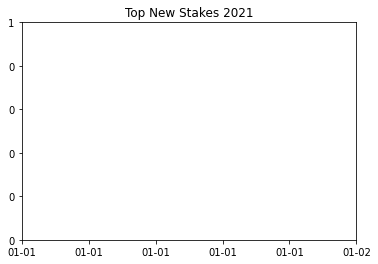

In [14]:
query = """
        SELECT 
                date_trunc('day', created_at) as Day, 
                candidate as Candidate,
                SUM(CAST(amount AS double) / power(10, 18)) AS Amount
        FROM 
                casimir_etl_database_dev.casimir_etl_event_table_dev
        WHERE 
                type = 'create_stake' AND year(created_at) = 2021
        GROUP BY 
                date_trunc('day', created_at),
                candidate
        ORDER BY 
                Amount DESC
        LIMIT 10
        """
        
dataframe = db_query(query)

_, ax = plt.subplots()
ax.set_title('Top New Stakes 2021')
ax.xaxis.set_major_formatter(month_day)
ax.yaxis.set_major_formatter(number_commas)
cmap = get_cmap(len(dataframe))
for index, (key,group) in enumerate(dataframe.groupby('Candidate')):
        group.plot.scatter(ax=ax, x='Day', y='Amount', label=key, color=cmap(index), legend=True)